# Flatness v.s. Generalization - Part 2

# Number of parameters v.s. Generalization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
torch.manual_seed(1)

## Datasets

### MNIST

In [3]:
# The training data
mnist_training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# The testing data
mnist_test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

## Training Function

In [4]:
def train(args, model, train_loader, loss_func, optimizer, epoch):
    model.train()
    loss = None
    correct = 0
    sensitivity = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()

        froGrad = 0
        count = 0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = p.grad
                froGrad_norm = torch.linalg.norm(grad).numpy()
                froGrad += froGrad_norm
                count += 1
        sensitivity = froGrad / count

        if batch_idx % args["log_interval"] == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSensitivity: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                    sensitivity,
                )
            )
    return correct / len(train_loader.dataset), loss.item(), sensitivity

## Testing Function

In [5]:
def test(model, loss_func, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_func(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

    return correct / len(test_loader.dataset), test_loss

## 5 Models

In [6]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.fc1 = nn.Linear(784, 240)
        self.fc2 = nn.Linear(240, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.fc1 = nn.Linear(784, 2000)
        self.fc2 = nn.Linear(2000, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
class Model5(nn.Module):
    def __init__(self):
        super(Model5, self).__init__()
        self.fc1 = nn.Linear(784, 4000)
        self.fc2 = nn.Linear(4000, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
training_acc_arr = []
training_loss_arr = []
testing_acc_arr = []
testing_loss_arr = []
sensitivities = []

In [12]:
args = {
    "log_interval": 200,
    "lr": 1e-3,
    "epochs": 1,
    "batch_sizes": [64, 256, 512, 1014, 2048],
}

In [13]:
models = [
    Model1(),
    Model2(),
    Model3(),
    Model4(),
    Model5(),
]

In [14]:
idx = 1
for model, batch_size in zip(models, args["batch_sizes"]):

    print("Model" + str(idx))
    idx += 1

    mnist_train_dataloader = DataLoader(
        mnist_training_data, batch_size=batch_size, shuffle=True
    )
    mnist_test_dataloader = DataLoader(mnist_test_data, batch_size=batch_size)

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=args["lr"])

    training_acc, training_loss, sensitivitiy = 0, 0, 0
    testing_acc, testing_loss = 0, 0
    for epoch in range(1, args["epochs"] + 1):
        training_acc, training_loss, sensitivity = train(
            args, model, mnist_train_dataloader, loss_func, optimizer, epoch
        )
        testing_acc, testing_loss = test(model, loss_func, mnist_test_dataloader)
    training_acc_arr.append(training_acc)
    training_loss_arr.append(training_loss)
    sensitivities.append(sensitivity)
    testing_acc_arr.append(testing_acc)
    testing_loss_arr.append(testing_loss)

Model1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293801	Sensitivity: 0.246010
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.285110	Sensitivity: 0.389288
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.204433	Sensitivity: 0.239883
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.320602	Sensitivity: 0.393754
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.260673	Sensitivity: 0.295090

Test set: Average loss: 0.0024, Accuracy: 9554/10000 (96%)

Model2
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302970	Sensitivity: 0.232883
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.268597	Sensitivity: 0.155771

Test set: Average loss: 0.0008, Accuracy: 9447/10000 (94%)

Model3
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312692	Sensitivity: 0.261938

Test set: Average loss: 0.0005, Accuracy: 9347/10000 (93%)

Model4
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303734	Sensitivity: 0.267265

Test set: Average loss: 0.0002, Accuracy: 9292/10000 (93%)

Model5
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298746	Sensitivity: 0.315301

Test set: Average loss: 0

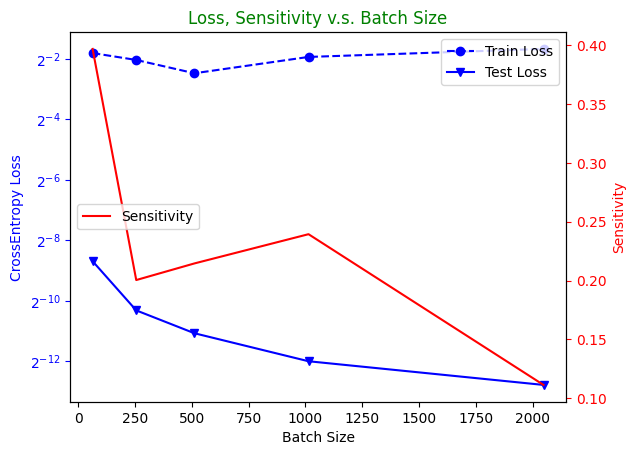

In [15]:
fig, ax = plt.subplots()
ax.plot(
    args["batch_sizes"], training_loss_arr, color="Blue", marker="o", linestyle="dashed"
)
ax.plot(args["batch_sizes"], testing_loss_arr, color="Blue", marker="v")
ax.legend(["Train Loss", "Test Loss"], loc="upper right")
ax.set_xlabel("Batch Size")
ax.set_ylabel("CrossEntropy Loss", color="blue")
ax.set_yscale("log", base=2)
ax.tick_params(axis="y", colors="blue")
ax.set_title("Loss, Sensitivity v.s. Batch Size", color="g")

ax2 = ax.twinx()
ax2.plot(args["batch_sizes"], sensitivities, color="red")
ax2.set_xlabel("Batch")
ax2.set_ylabel("Sensitivity", color="red")
ax2.tick_params(axis="y", colors="red")
ax2.legend(["Sensitivity"], loc="center left")

plt.show()